# Testing DEMV on Park Datset

- Positive Label: `score_cut=0`
- Protected group: males with more than 65 years (`age = 1 && sex = 0`)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss, GridSearch

from utils import *
from demv import DEMV

sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2

In [2]:
def prepare_data():
  data = pd.read_csv('data2/park.csv')
  data.drop(['subject#', 'a', 'y', 'yhat', 'motor_UPDRS', 'total_UPDRS', 'test_time'], axis=1, inplace=True)
  data.loc[data['age']<65, 'age'] = 0
  data.loc[data['age']>=65, 'age'] = 1
  data['score_cut'].replace({
    'Mild': 0,
    'Moderate': 1,
    'Severe': 2
  }, inplace=True)
  changed_labels = data[(data['age']==1)&(data['sex']==1)&(data['score_cut']==1)].sample(n=200).index
  data.loc[changed_labels, 'score_cut'] = 0
  return data

In [3]:
data = prepare_data()
data

,age,sex,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,score_cut
0,1,0,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006,1
1,1,0,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810,1
2,1,0,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014,1
3,1,0,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277,1
4,1,0,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,0,0,0.00406,0.000031,0.00167,0.00168,0.00500,0.01896,0.160,0.00973,0.01133,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367,1
5871,0,0,0.00297,0.000025,0.00119,0.00147,0.00358,0.02315,0.215,0.01052,0.01277,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621,1
5872,0,0,0.00349,0.000025,0.00152,0.00187,0.00456,0.02499,0.244,0.01371,0.01456,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157,1
5873,0,0,0.00281,0.000020,0.00128,0.00151,0.00383,0.01484,0.131,0.00693,0.00870,0.01307,0.02078,0.007984,24.422,0.56865,0.56327,0.14204,1


In [4]:
label = 'score_cut'
sensitive_vars = ['age', 'sex']
protected_group = {'age': 1, 'sex': 0}
positive_label = 0

In [5]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression())
])

## Biased classifier

In [6]:
model, metrics = cross_val(pipeline, data, label, protected_group, sensitive_vars, positive_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [7]:
print_metrics(metrics)

Statistical parity:  -0.204  +-  0.043
Disparate impact:  0.441  +-  0.093
Zero one loss:  0.254  +-  0.047
F1 score:  0.465  +-  0.027
Accuracy score:  0.502  +-  0.022


## DEMV application

In [8]:
demv = DEMV(round_level=1)
demv_data = data.copy()

In [9]:
model, demv_metrics = cross_val(pipeline, demv_data, label, protected_group, sensitive_vars, positive_label, debiaser=demv)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [10]:
print_metrics(demv_metrics)

Statistical parity:  -0.062  +-  0.048
Disparate impact:  0.809  +-  0.134
Zero one loss:  0.231  +-  0.06
F1 score:  0.428  +-  0.02
Accuracy score:  0.489  +-  0.017


## DEMV Evaluation

In [11]:
demv.get_iters()

179

In [12]:
180/34

5.294117647058823

In [13]:
metrics = eval_demv(34, 180, data.copy(), pipeline, label, protected_group, sensitive_vars, positive_label=positive_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

##  Blackbox Postprocessing

In [14]:
model, blackboxmetrics, pred = cross_val2(pipeline, data, label, protected_group, sensitive_vars, positive_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2906  0.7455
1  0.4556  0.6220
2  0.0365  0.0000

1
      fpr     tpr
0  0.1415  0.4095
1  0.6553  0.7680
2  0.0804  0.1000


And loss is 0.5119


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2906  0.7455
1  0.4556  0.6220
2  0.0365  0.0000

1
      fpr     tpr
0  0.1434  0.3412
1  0.7188  0.7697
2  0.0720  0.0561


And loss is 0.5198

[0.20755733 0.15684002 0.63560265]
[0.09863025 0.13812762 0.76324213]
[0.06051335 0.12640254 0.81308411]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2783  0.7308
1  0.4713  0.6375
2  0.0379  0.0000

1
      fpr     tpr
0  0.1331  0.4343
1  0.6321  0.7515
2  0.0858  0.1277


And loss is 0.4877

[0.3220783  0.16361578 0.51430592]
[0.13773085 0.12052377 0.74174538]
[0.08814774 0.11448622 0.79736604]
[0.3220783  0.18038912 0.49753258]
[0.13675468 0.12052377 0.74272155]
[0.09726457 0.10536939 0.79736604]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2830  0.764

/Users/andreadangelo/Desktop/fairness/balancers.py:634: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_pred_vecs = np.array([tools.p_vec(y_[ids]) for ids in group_ids])



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3113  0.7826
1  0.4568  0.6338
2  0.0085  0.0000

1
      fpr     tpr
0  0.1250  0.4095
1  0.6524  0.7778
2  0.0924  0.1016


And loss is 0.5293

[0.17942181 0.07683715 0.74374105]
[0.08395481 0.11957244 0.79647275]
[0.04585224 0.1438046  0.81034316]
[0.17942181 0.09785272 0.72272547]
[0.06603004 0.11957244 0.81439751]
[0.07738546 0.11227137 0.81034316]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3191  0.7455
1  0.4512  0.5373
2  0.0410  0.0000

1
      fpr     tpr
0  0.1413  0.4095
1  0.6481  0.8182
2  0.0444  0.1081


And loss is 0.4962

[0.22524605 0.28841421 0.48633974]
[0.1217657  0.28601402 0.59222028]
[0.03357326 0.31417532 0.65225142]
[0.22524605 0.33587497 0.43887898]
[0.10229347 0.28601402 0.61169251]
[0.08772356 0.26002503 0.65225142]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3617  0.8000
1  0.3043  0.5867
2  0.0400  0.0000

1
      fpr     tpr
0  0.1566  0.4095
1  0.6413  0.7485
2  0.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3540  0.5152
1  0.5000  0.5432
2  0.0816  0.0000

1
      fpr     tpr
0  0.1200  0.4862
1  0.5688  0.7435
2  0.1167  0.1743


And loss is 0.5034


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3540  0.5152
1  0.5000  0.5432
2  0.0816  0.0000

1
      fpr     tpr
0  0.1265  0.4433
1  0.5946  0.7333
2  0.1221  0.1364


And loss is 0.5198

[0.07255776 0.60491663 0.32252561]
[0.05216571 0.5337445  0.41408979]
[0.04401482 0.54127779 0.41470739]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3400  0.5161
1  0.5106  0.5441
2  0.0846  0.0000

1
      fpr     tpr
0  0.1269  0.4953
1  0.5238  0.7247
2  0.1228  0.2195


And loss is 0.4915

[0.63731526 0.166616   0.19606874]
[0.56670643 0.21346316 0.21983041]
[0.60640961 0.13039674 0.26319365]
[0.63731526 0.12662728 0.23605745]
[0.5946056  0.21346316 0.19193123]
[0.54642901 0.19037734 0.26319365]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3704  0.515

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2951  0.6081
1  0.5263  0.6098
2  0.0321  0.0000

1
      fpr     tpr
0  0.1232  0.4907
1  0.5507  0.7946
2  0.0683  0.2323


And loss is 0.4592


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2951  0.6081
1  0.5263  0.6098
2  0.0321  0.0000

1
      fpr     tpr
0  0.1292  0.4301
1  0.6080  0.7962
2  0.0680  0.1566


And loss is 0.4839

[0.76790557 0.1290318  0.10306263]
[0.70591193 0.13372989 0.16035818]
[0.74386604 0.05231872 0.20381524]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2411  0.6250
1  0.5179  0.6806
2  0.0347  0.0000

1
      fpr     tpr
0  0.1245  0.5096
1  0.5000  0.7803
2  0.0722  0.3088


And loss is 0.4272

[0.43631114 0.37577582 0.18791304]
[0.17452446 0.71459359 0.11088195]
[0.15707201 0.73219482 0.11073317]
[0.43631114 0.40536887 0.15831999]
[0.14137272 0.71459359 0.14403368]
[0.23677582 0.65249101 0.11073317]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3186  0.656

/Users/andreadangelo/Desktop/fairness/balancers.py:634: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_pred_vecs = np.array([tools.p_vec(y_[ids]) for ids in group_ids])



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3118  0.6081
1  0.5392  0.5077
2  0.0360  0.0000

1
      fpr     tpr
0  0.1216  0.4907
1  0.5510  0.8503
2  0.0291  0.2386


And loss is 0.4453

[0.48177966 0.36004157 0.15817877]
[0.39041558 0.4046653  0.20491912]
[0.28208994 0.3431121  0.37479796]
[0.48177966 0.38742082 0.13079952]
[0.38345753 0.4046653  0.21187718]
[0.30911309 0.31608895 0.37479796]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3846  0.6522
1  0.4000  0.5571
2  0.0360  0.0000

1
      fpr     tpr
0  0.1336  0.4907
1  0.5463  0.7697
2  0.0733  0.2371


And loss is 0.4585

[0.26092603 0.39124788 0.34782609]
[0.14860359 0.29425356 0.55714286]
[0.17146568 0.25710575 0.57142857]
[0.26092603 0.42828408 0.31078989]
[0.15927066 0.29425356 0.54647579]
[0.14470885 0.28386258 0.57142857]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3700  0.6842
1  0.4353  0.4722
2  0.0775  0.0000

1
      fpr     tpr
0  0.1331  0.3821
1  0.6610  0.7949
2  0.0535  0.1327


And loss is 0.5068


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3700  0.6842
1  0.4353  0.4722
2  0.0775  0.0000

1
      fpr     tpr
0  0.1439  0.2970
1  0.7194  0.7898
2  0.0542  0.0842


And loss is 0.5274

[0.05563241 0.90280546 0.04156213]
[0.03387872 0.90200297 0.06411832]
[0.02032723 0.89546224 0.08421053]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3700  0.6842
1  0.4353  0.4722
2  0.0775  0.0000

1
      fpr     tpr
0  0.1451  0.4017
1  0.6146  0.7833
2  0.0539  0.1733


And loss is 0.4820

[0.62573201 0.29786493 0.07640306]
[0.54009802 0.33136975 0.12853223]
[0.57040669 0.2254539  0.20413942]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3261  0.6786
1  0.4405  0.5156
2  0.0833  0.0000

1
      fpr     tpr
0  0.1303  0.4536
1  0.6333  0.7953
2  0.0597 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3022  0.5918
1  0.5444  0.5714
2  0.0816  0.0000

1
      fpr     tpr
0  0.1172  0.4273
1  0.5893  0.8125
2  0.0804  0.1842


And loss is 0.4966


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3022  0.5918
1  0.5444  0.5714
2  0.0816  0.0000

1
      fpr     tpr
0  0.1260  0.3448
1  0.6503  0.8165
2  0.0694  0.1458


And loss is 0.5123

[0.47899067 0.12688679 0.39412254]
[0.31024221 0.21462347 0.47513432]
[0.27278468 0.22358615 0.50362917]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2941  0.5652
1  0.5632  0.5789
2  0.0851  0.0000

1
      fpr     tpr
0  0.1120  0.4340
1  0.5691  0.7987
2  0.0830  0.2195


And loss is 0.4858

[0.22400458 0.17855849 0.59743693]
[0.13571615 0.3051187  0.55916515]
[0.11387885 0.26100868 0.62511246]
[0.22400458 0.18739574 0.58859968]
[0.13452946 0.3051187  0.56035184]
[0.11866869 0.25621885 0.62511246]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2880  0.608

/Users/andreadangelo/Desktop/fairness/balancers.py:634: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_pred_vecs = np.array([tools.p_vec(y_[ids]) for ids in group_ids])



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2685  0.5918
1  0.5844  0.5250
2  0.0930  0.0000

1
      fpr     tpr
0  0.1217  0.4273
1  0.5924  0.8519
2  0.0515  0.1683


And loss is 0.4849

[0.38928317 0.23638489 0.37433194]
[0.23021401 0.40450007 0.36528592]
[0.02349123 0.51336748 0.4631413 ]
[0.38928317 0.31908374 0.29163309]
[0.1744336  0.40450007 0.42106633]
[0.18012485 0.35673385 0.4631413 ]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3661  0.6304
1  0.4143  0.5341
2  0.0896  0.0000

1
      fpr     tpr
0  0.1260  0.4273
1  0.5694  0.7975
2  0.0842  0.2020


And loss is 0.4849

[0.54179461 0.22680609 0.2313993 ]
[0.3027426 0.3182534 0.379004 ]
[0.35808265 0.22796972 0.41394763]
[0.54179461 0.1995204  0.25868499]
[0.30641065 0.3182534  0.37533595]
[0.3280866  0.25796577 0.41394763]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3471  0.5070
1  0.5243  0.6067
2  0.0375  0.0000

1
      fpr     tpr
0  0.1796  0.4685
1  0.5419  0.7812
2  0.0561  0.1630


And loss is 0.4770


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3471  0.5070
1  0.5243  0.6067
2  0.0375  0.0000

1
      fpr     tpr
0  0.1883  0.4742
1  0.5500  0.7784
2  0.0440  0.1270


And loss is 0.4678

[0.6498587  0.18776434 0.16237696]
[0.65577499 0.11858048 0.22564453]
[0.65979949 0.07290053 0.26729997]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3333  0.5455
1  0.5000  0.6184
2  0.0423  0.0000

1
      fpr     tpr
0  0.1840  0.5000
1  0.5191  0.7544
2  0.0618  0.1899


And loss is 0.4716

[0.45936616 0.29175498 0.24887887]
[0.4337485  0.17686673 0.38938477]
[0.42860308 0.11918617 0.45221076]
[0.45936616 0.29397822 0.24665562]
[0.45196603 0.17686673 0.37116723]
[0.38949102 0.15829822 0.45221076]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3621  0.537

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3077  0.5875
1  0.4790  0.6154
2  0.0506  0.0256

1
      fpr     tpr
0  0.1368  0.3524
1  0.7000  0.7941
2  0.0509  0.0957


And loss is 0.5247


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3077  0.5875
1  0.4790  0.6154
2  0.0506  0.0256

1
      fpr     tpr
0  0.1481  0.2614
1  0.7542  0.7961
2  0.0500  0.0440


And loss is 0.5379

[0.03229535 0.24616225 0.7215424 ]
[0.01868232 0.18525006 0.79606762]
[0.01755307 0.16926012 0.81318681]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3070  0.5875
1  0.4790  0.6133
2  0.0516  0.0256

1
      fpr     tpr
0  0.1555  0.3750
1  0.6702  0.7603
2  0.0579  0.1087


And loss is 0.5246

[0.09314482 0.31240878 0.5944464 ]
[0.04862028 0.20976682 0.7416129 ]
[0.04878289 0.17236964 0.77884747]
[0.09314482 0.35140545 0.55544973]
[0.05211279 0.20976682 0.73812039]
[0.04322173 0.1779308  0.77884747]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3130  0.571

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2783  0.5588
1  0.5673  0.5823
2  0.0476  0.0278

1
      fpr     tpr
0  0.1049  0.5000
1  0.5636  0.8152
2  0.0795  0.1667


And loss is 0.4702


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2783  0.5588
1  0.5673  0.5823
2  0.0476  0.0278

1
      fpr     tpr
0  0.1084  0.4583
1  0.5912  0.8293
2  0.0769  0.1294


And loss is 0.4773

[0.7650586  0.12520369 0.10973771]
[0.71147965 0.16245612 0.12606423]
[0.74127652 0.0980665  0.16065698]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2667  0.5806
1  0.5612  0.5797
2  0.0534  0.0278

1
      fpr     tpr
0  0.1066  0.5043
1  0.5357  0.7939
2  0.0851  0.2025


And loss is 0.4640

[0.74188791 0.13096865 0.12714344]
[0.67835232 0.15294058 0.1687071 ]
[0.71167218 0.05536904 0.23295879]
[0.74188791 0.08561559 0.1724965 ]
[0.71465948 0.15294058 0.13239994]
[0.63780502 0.12923619 0.23295879]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2991  0.584

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3065  0.6709
1  0.5038  0.5833
2  0.0265  0.0000

1
      fpr     tpr
0  0.1519  0.3509
1  0.6376  0.7711
2  0.0857  0.1154


And loss is 0.5315


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3065  0.6709
1  0.5038  0.5833
2  0.0265  0.0000

1
      fpr     tpr
0  0.1552  0.3118
1  0.6851  0.7778
2  0.0717  0.0795


And loss is 0.5398

[0.03467526 0.13795662 0.82736812]
[0.02117055 0.17172422 0.80710523]
[0.0118339  0.17146654 0.81669956]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2909  0.6753
1  0.5039  0.5862
2  0.0296  0.0000

1
      fpr     tpr
0  0.1502  0.3704
1  0.6033  0.7580
2  0.0906  0.1579


And loss is 0.5133

[0.28786466 0.13343134 0.578704  ]
[0.21499792 0.24536975 0.53963232]
[0.17404374 0.29056602 0.53539024]
[0.28786466 0.17741221 0.53472313]
[0.17400554 0.24536975 0.58062471]
[0.24032539 0.22428437 0.53539024]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3089  0.670

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3551  0.6935
1  0.4571  0.5053
2  0.0764  0.0000

1
      fpr     tpr
0  0.1098  0.4715
1  0.5751  0.8182
2  0.0758  0.1727


And loss is 0.4991


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3551  0.6935
1  0.4571  0.5053
2  0.0764  0.0000

1
      fpr     tpr
0  0.1272  0.4200
1  0.6062  0.8222
2  0.0681  0.1398


And loss is 0.5133

[0.47502219 0.13738327 0.38759454]
[0.2739663  0.26898197 0.45705173]
[0.175211   0.32849169 0.4962973 ]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3385  0.6949
1  0.4608  0.5287
2  0.0753  0.0000

1
      fpr     tpr
0  0.1091  0.4874
1  0.5400  0.7986
2  0.0814  0.2099


And loss is 0.4830

[0.18977022 0.13203162 0.67819817]
[0.10358357 0.26079219 0.63562423]
[0.06985869 0.23763674 0.69250457]
[0.18977022 0.15124603 0.65898376]
[0.09164842 0.26079219 0.64755939]
[0.09376694 0.21372848 0.69250457]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3543  0.741

## Plot

In [15]:
df = prepareplots(metrics, 'park')

In [16]:
points = preparepoints(blackboxmetrics, 170)

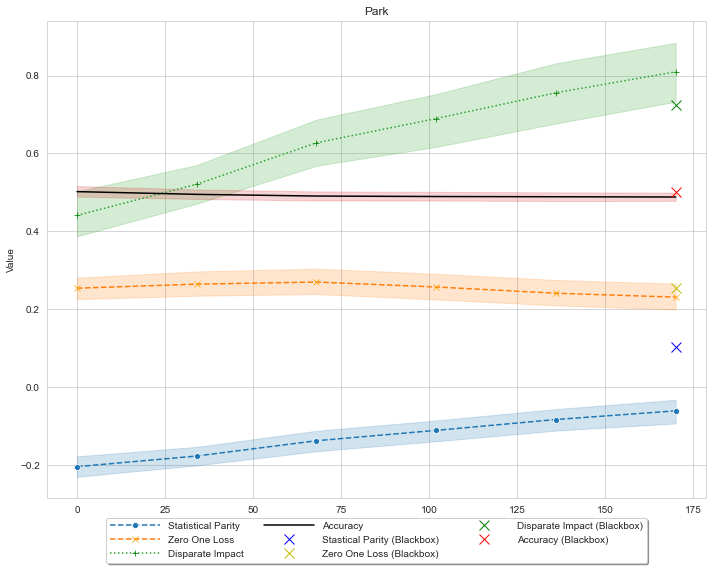

In [17]:
plot_metrics_curves(df, points, 'Park')

In [18]:
unprivpergentage(data, protected_group, 89)

Dataset size: 5875
Unprivileged group size: 2318
Percentage of unprivileged group: 39.45531914893617
Number of iterations: 89


In [19]:
save_metrics('blackbox', 'park', blackboxmetrics)